In [19]:
from tauso.off_target.Roni.off_target_pipeline.get_premRNA_sequences import general_exp_data
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
import pickle
from notebooks.preprocessing import preprocess_aso_data
from notebooks.consts import UPDATED_CSV, CANONICAL_GENE

aso_df = preprocess_aso_data(UPDATED_CSV)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Preprocessing complete. Final valid rows: 29987


In [106]:
df = pd.read_csv('off_target.Unknown.general.top100.cutoff1100.csv')

In [107]:
feat = 'off_target_score_general_Unknown_n100_c1100'

In [108]:
from notebooks.consts import INHIBITION

correlation = df[feat].corr(aso_df[INHIBITION])

print(f"Correlation: {correlation}")

Correlation: 0.007118370334023692


In [109]:
import pandas as pd
from scipy.stats import pearsonr
from notebooks.consts import CANONICAL_GENE, CELL_LINE

# 1. Align the dataframes on the 'index' column
merged_df = pd.merge(
    df[['index', feat]],
    aso_df[['index', INHIBITION, CELL_LINE, CANONICAL_GENE]],
    on='index'
).dropna(subset=[feat, INHIBITION])

col_feature = feat
col_target = INHIBITION

# 2. Function to get correlation and p-value
def get_stats(data, label):
    corr, p_value = pearsonr(data[col_feature], data[col_target])
    print(f"--- {label} ---")
    print(f"Correlation: {corr:.4f}")
    print(f"P-value:     {p_value:.4e}")
    print(f"Sample Size: {len(data)}\n")
    return corr, p_value

# Full Dataset Correlation
get_stats(merged_df, "Full Dataset")

# 3. Filter for non-zero features
filtered_df = merged_df[merged_df[col_feature] > 0]
get_stats(filtered_df, f"Filtered (where {col_feature} != 0)")

--- Full Dataset ---
Correlation: -0.0135
P-value:     1.9470e-02
Sample Size: 29987

--- Filtered (where off_target_score_general_Unknown_n100_c1100 != 0) ---
Correlation: -0.0241
P-value:     3.0094e-02
Sample Size: 8107



(np.float64(-0.024088137372684584), np.float64(0.03009413802472243))

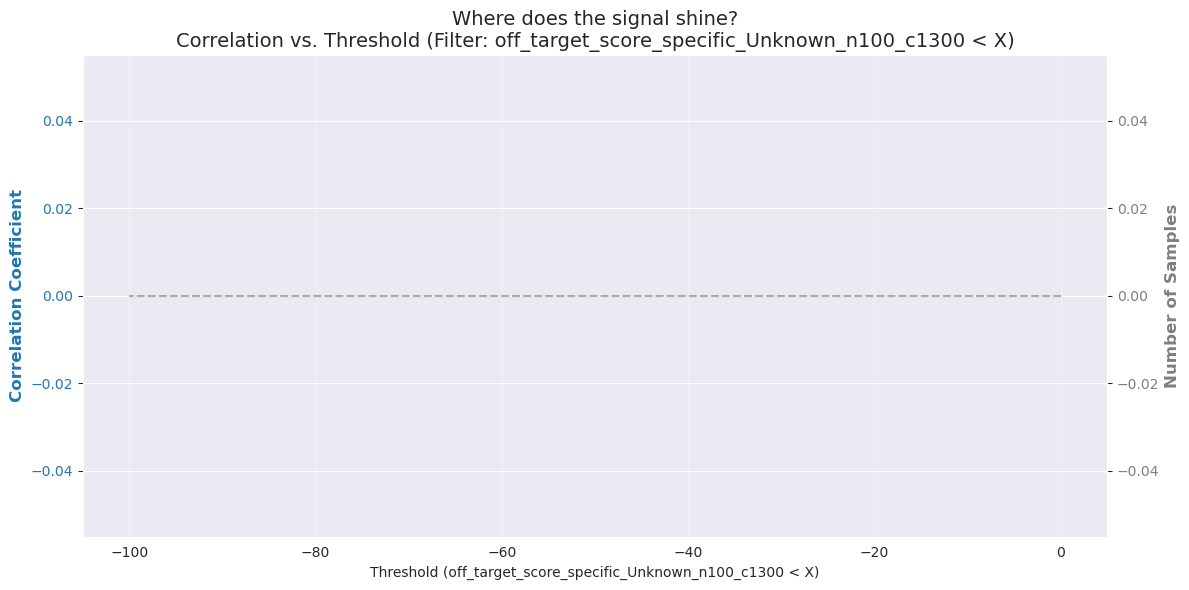

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# ================= CONFIGURATION =================
# Ensure these match your variables
df_to_analyze = merged_df       # The DataFrame
feature_col = feat       # The column you are filtering (e.g. 'prediction')
target_col = INHIBITION         # The target column (UPDATE THIS if your target has a different name)
# =================================================

# 1. Define the thresholds to test
# We sweep from the minimum value up to -100 (or close to 0)
min_val = df_to_analyze[feature_col].min()
thresholds = np.linspace(min_val, -100, 50)

correlations = []
counts = []

# 2. Loop through each threshold
for t in thresholds:
    # Logic: Keep everything BELOW the threshold
    subset = df_to_analyze[df_to_analyze[feature_col] < t]

    # Calculate stats only if we have enough data (e.g. > 10 points)
    if len(subset) > 10:
        corr = subset[feature_col].corr(subset[target_col])
        correlations.append(corr)
        counts.append(len(subset))
    else:
        correlations.append(np.nan)
        counts.append(0)

# 3. Plot the Dual-Axis Chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-Axis: Correlation
color_corr = 'tab:blue'
ax1.set_xlabel(f'Threshold ({feature_col} < X)')
ax1.set_ylabel('Correlation Coefficient', color=color_corr, fontsize=12, fontweight='bold')
ax1.plot(thresholds, correlations, color=color_corr, linewidth=3, label='Correlation')
ax1.tick_params(axis='y', labelcolor=color_corr)
ax1.grid(True, alpha=0.3)

# Right Y-Axis: Sample Count
ax2 = ax1.twinx()
color_count = 'tab:gray'
ax2.set_ylabel('Number of Samples', color=color_count, fontsize=12, fontweight='bold')
ax2.fill_between(thresholds, counts, color=color_count, alpha=0.1) # Shaded area for volume
ax2.plot(thresholds, counts, color=color_count, linestyle='--', alpha=0.6, label='Count')
ax2.tick_params(axis='y', labelcolor=color_count)

plt.title(f'Where does the signal shine?\nCorrelation vs. Threshold (Filter: {feature_col} < X)', fontsize=14)
plt.tight_layout()
plt.show()

In [62]:
df.columns

Index(['index', 'off_target_score_general_ARTM_log_n25_c1200'], dtype='object')

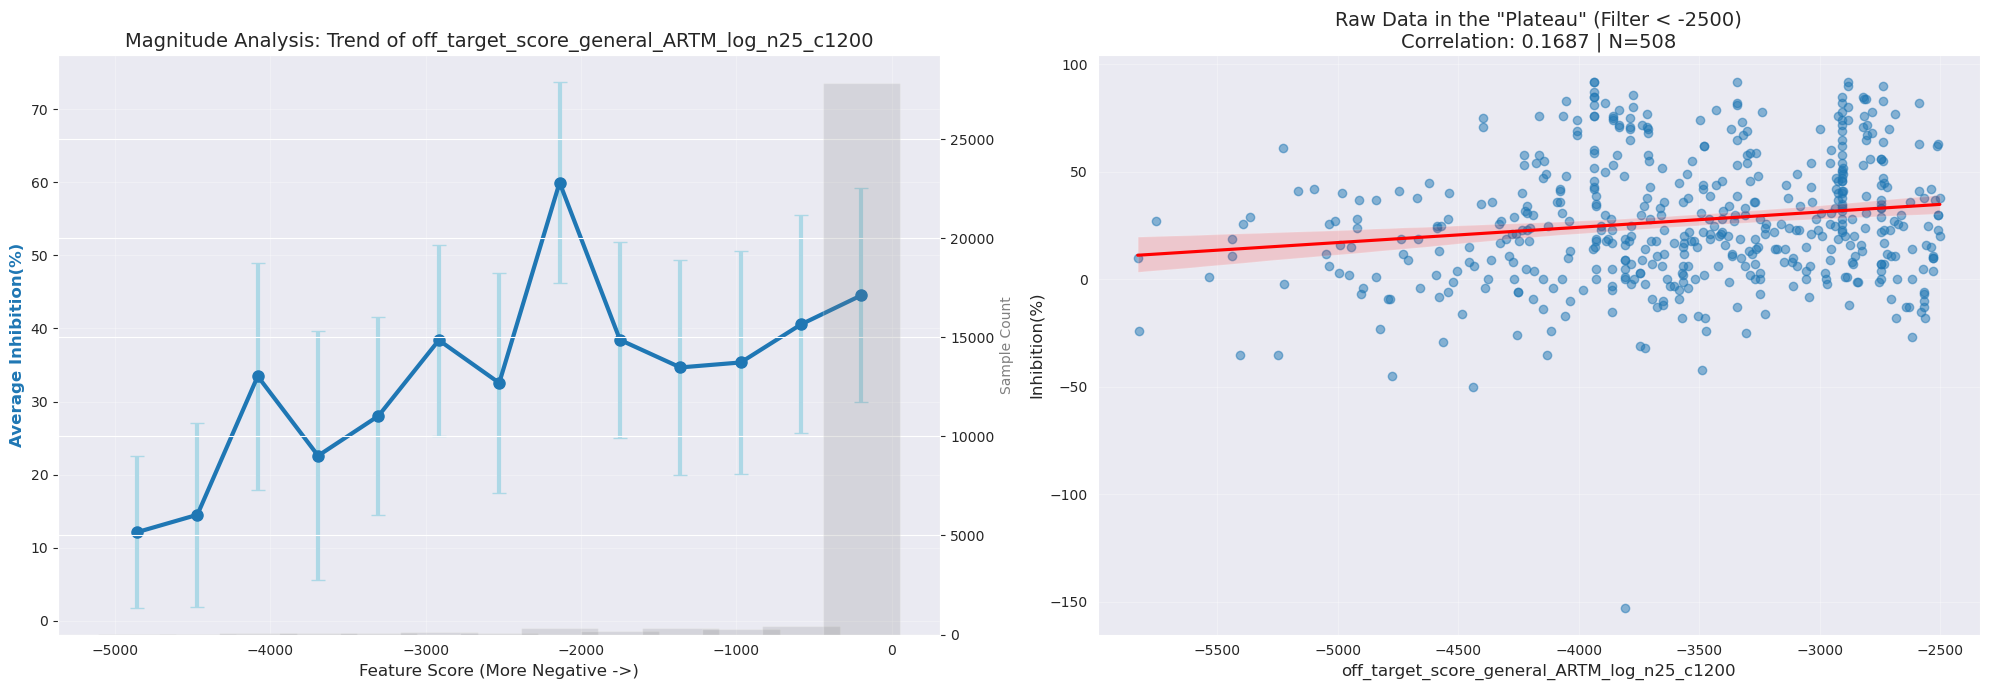

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ================= CONFIGURATION =================
df = merged_df
feature_col = 'off_target_score_general_ARTM_log_n25_c1200'  # Your "Winner" Feature
target_col = INHIBITION
# =================================================

# Set up the figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# --- PLOT 1: The Magnitude Analysis (Binned Mean) ---
# Filter for relevant data (removing 0s to see the trend in the negatives)
# subset = df[df[feature_col] < -100].copy()
subset = df.copy()
# Create 15 bins for the feature range
subset['bin'] = pd.cut(subset[feature_col], bins=15)

# Calculate stats per bin (added observed=True to silence warning)
bin_stats = subset.groupby('bin', observed=True)[target_col].agg(['mean', 'count', 'std']).reset_index()

# FIX: Access the 'bin' column, not the original feature name
bin_stats['bin_center'] = bin_stats['bin'].apply(lambda x: x.mid)

# Filter out empty bins
bin_stats = bin_stats[bin_stats['count'] > 10]

# Plot Mean Target with Error Bars
ax1.errorbar(bin_stats['bin_center'], bin_stats['mean'], yerr=bin_stats['std']/2,
             fmt='-o', color='tab:blue', ecolor='lightblue', capsize=5, linewidth=3, markersize=8)
ax1.set_title(f'Magnitude Analysis: Trend of {feature_col}', fontsize=14)
ax1.set_xlabel('Feature Score (More Negative ->)', fontsize=12)
ax1.set_ylabel(f'Average {target_col}', fontsize=12, fontweight='bold', color='tab:blue')
ax1.grid(True, alpha=0.3)

# Add volume bars
ax1_twin = ax1.twinx()
ax1_twin.bar(bin_stats['bin_center'], bin_stats['count'], width=500, color='gray', alpha=0.2)
ax1_twin.set_ylabel('Sample Count', color='gray')


# --- PLOT 2: The "Sweet Spot" Scatter (Threshold < -2500) ---
threshold = -2500
sweet_spot = df[df[feature_col] < threshold]
if len(sweet_spot) > 2:
    corr = sweet_spot[feature_col].corr(sweet_spot[target_col])

    sns.regplot(data=sweet_spot, x=feature_col, y=target_col, ax=ax2,
                scatter_kws={'alpha': 0.5, 'color': 'tab:blue'}, line_kws={'color': 'red'})

    ax2.set_title(f'Raw Data in the "Plateau" (Filter < {threshold})\nCorrelation: {corr:.4f} | N={len(sweet_spot)}', fontsize=14)
else:
    ax2.text(0.5, 0.5, "Not enough data for scatter", ha='center')

ax2.set_xlabel(feature_col, fontsize=12)
ax2.set_ylabel(target_col, fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_606292/3119458501.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cohort_df, x='Cohort', y='Correlation', ax=ax3, palette=colors)
/tmp/ipykernel_606292/3119458501.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


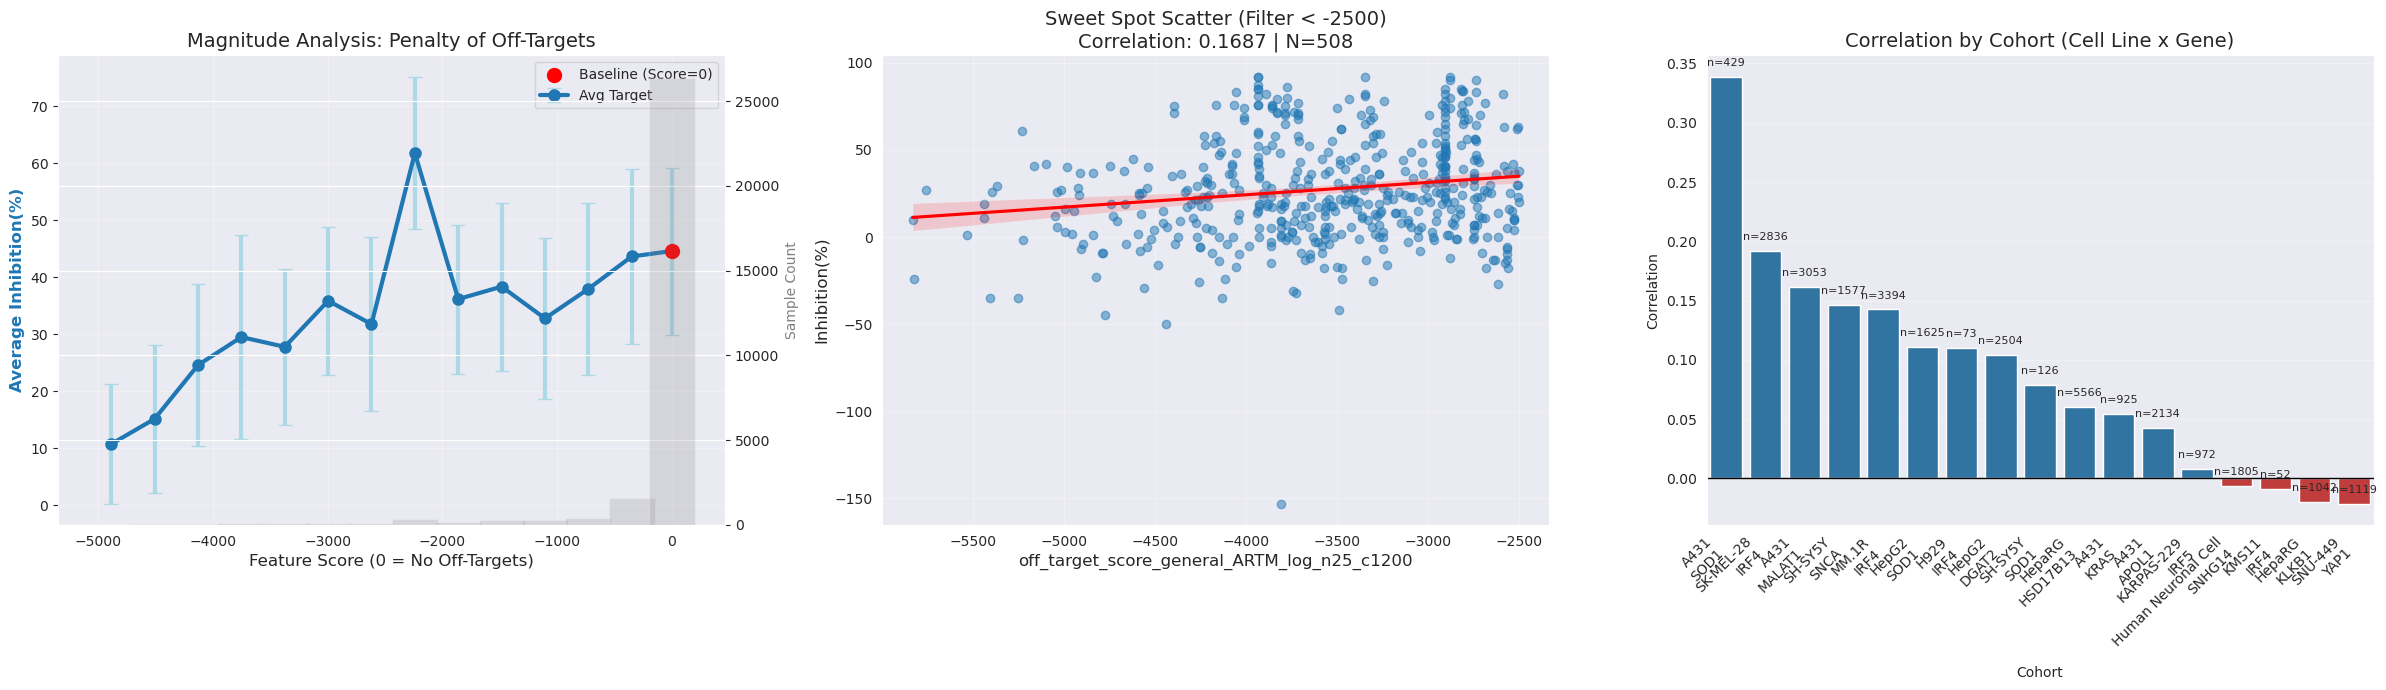

In [68]:
from notebooks.consts import CANONICAL_GENE, CELL_LINE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ================= CONFIGURATION =================
# Ensure these match your actual variable names
df = merged_df
feature_col = 'off_target_score_general_ARTM_log_n25_c1200'
target_col = INHIBITION # Or whatever your target variable is named
# =================================================

# Set up the figure with 3 subplots (Extended for Cohort Analysis)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))

# ==============================================================================
# PLOT 1: The Magnitude Analysis (Trends including 0)
# ==============================================================================

# 1. Split Data: Negatives (Signal) vs. Zero (No Signal)
negatives = df[df[feature_col] < -10].copy() # Cutoff slightly below 0 to avoid float issues
zeros = df[df[feature_col] == 0].copy()

# 2. Bin the Negatives
# We create bins just for the negative part to get granular resolution there
negatives['bin'] = pd.cut(negatives[feature_col], bins=15)
bin_stats = negatives.groupby('bin', observed=True)[target_col].agg(['mean', 'count', 'std']).reset_index()
bin_stats['bin_center'] = bin_stats['bin'].apply(lambda x: x.mid)

# 3. Calculate Stats for the "Zero" Group
if len(zeros) > 0:
    zero_stats = pd.DataFrame({
        'bin': ['Zero (Baseline)'],
        'mean': [zeros[target_col].mean()],
        'count': [len(zeros)],
        'std': [zeros[target_col].std()],
        'bin_center': [0] # Place at 0 on X-axis
    })
    # Combine Negatives + Zero
    full_stats = pd.concat([bin_stats, zero_stats], ignore_index=True)
else:
    full_stats = bin_stats

# Sort by center so the line connects properly
full_stats = full_stats.sort_values('bin_center')
full_stats = full_stats[full_stats['count'] > 10] # Filter low-data bins

# 4. Plot
# Main Trend Line
ax1.errorbar(full_stats['bin_center'], full_stats['mean'], yerr=full_stats['std']/2,
             fmt='-o', color='tab:blue', ecolor='lightblue', capsize=5, linewidth=3, markersize=8, label='Avg Target')

# Highlight the Zero Point
ax1.scatter([0], full_stats[full_stats['bin_center']==0]['mean'], color='red', s=100, zorder=5, label='Baseline (Score=0)')

ax1.set_title(f'Magnitude Analysis: Penalty of Off-Targets', fontsize=14)
ax1.set_xlabel('Feature Score (0 = No Off-Targets)', fontsize=12)
ax1.set_ylabel(f'Average {target_col}', fontsize=12, fontweight='bold', color='tab:blue')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Volume Bars (Secondary Axis)
ax1_twin = ax1.twinx()
ax1_twin.bar(full_stats['bin_center'], full_stats['count'], width=400, color='gray', alpha=0.2)
ax1_twin.set_ylabel('Sample Count', color='gray')


# ==============================================================================
# PLOT 2: The "Sweet Spot" Scatter (Threshold < -2500)
# ==============================================================================
threshold = -2500
sweet_spot = df[df[feature_col] < threshold]

if len(sweet_spot) > 5:
    corr = sweet_spot[feature_col].corr(sweet_spot[target_col])
    sns.regplot(data=sweet_spot, x=feature_col, y=target_col, ax=ax2,
                scatter_kws={'alpha': 0.5, 'color': 'tab:blue'}, line_kws={'color': 'red'})
    ax2.set_title(f'Sweet Spot Scatter (Filter < {threshold})\nCorrelation: {corr:.4f} | N={len(sweet_spot)}', fontsize=14)
else:
    ax2.text(0.5, 0.5, "Not enough data (< 5 samples)", ha='center')

ax2.set_xlabel(feature_col, fontsize=12)
ax2.set_ylabel(target_col, fontsize=12)
ax2.grid(True, alpha=0.3)


# ==============================================================================
# PLOT 3: Cohort Analysis (Cell Line x Gene)
# ==============================================================================
cohort_data = []

# Group by the cross-product of Cell Line and Gene
# Use the sweet spot threshold (-2500) or 0 depending on where you want to check correlation.
# Usually, we check correlation on the *filtered* set to see if the signal holds,
# OR we check on the whole set (including 0) to see overall predictive power.
# Here we check on the WHOLE set (negatives vs 0) for maximum context.
cohort_groups = df.groupby([CELL_LINE, CANONICAL_GENE])

for (cell, gene), group in cohort_groups:
    # We only care if there is variance in the feature (some off-targets exist)
    if len(group) > 20 and group[feature_col].nunique() > 1:
        r = group[feature_col].corr(group[target_col])
        cohort_data.append({
            'Cohort': f"{cell}\n{gene}",
            'Correlation': r,
            'Count': len(group)
        })

cohort_df = pd.DataFrame(cohort_data).sort_values('Correlation', ascending=False)

if not cohort_df.empty:
    # Color bars by positive/negative correlation
    colors = ['tab:blue' if x > 0 else 'tab:red' for x in cohort_df['Correlation']]

    sns.barplot(data=cohort_df, x='Cohort', y='Correlation', ax=ax3, palette=colors)
    ax3.axhline(0, color='black', linewidth=1)
    ax3.set_title('Correlation by Cohort (Cell Line x Gene)', fontsize=14)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')

    # Add count labels on top of bars
    for i, p in enumerate(ax3.patches):
        ax3.annotate(f"n={cohort_df.iloc[i]['Count']}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
else:
    ax3.text(0.5, 0.5, "Not enough data per cohort", ha='center')

plt.tight_layout()
plt.show()